# Extended Isolation Forest in H2O-3 for unsupervised Anomaly Detection

Extended Isolation Forest (EIF) is an algorithm for unsupervised anomaly detection based on the Isolation Forest algorithm. The original Isolation Forest algorithm brings a brand new form of anomaly detection, although the algorithm suffers from bias due to tree branching. Extension of the algorithm mitigates the bias by adjusting the branching, and the original algorithm becomes just a special case.

The cause of the bias is that branching is defined by the similarity
to a binary search tree (BST). At each branching point the
feature and the value are chosen; this introduces the
bias since the branching point is parallel to one of the axes as you can see in the left picture below.




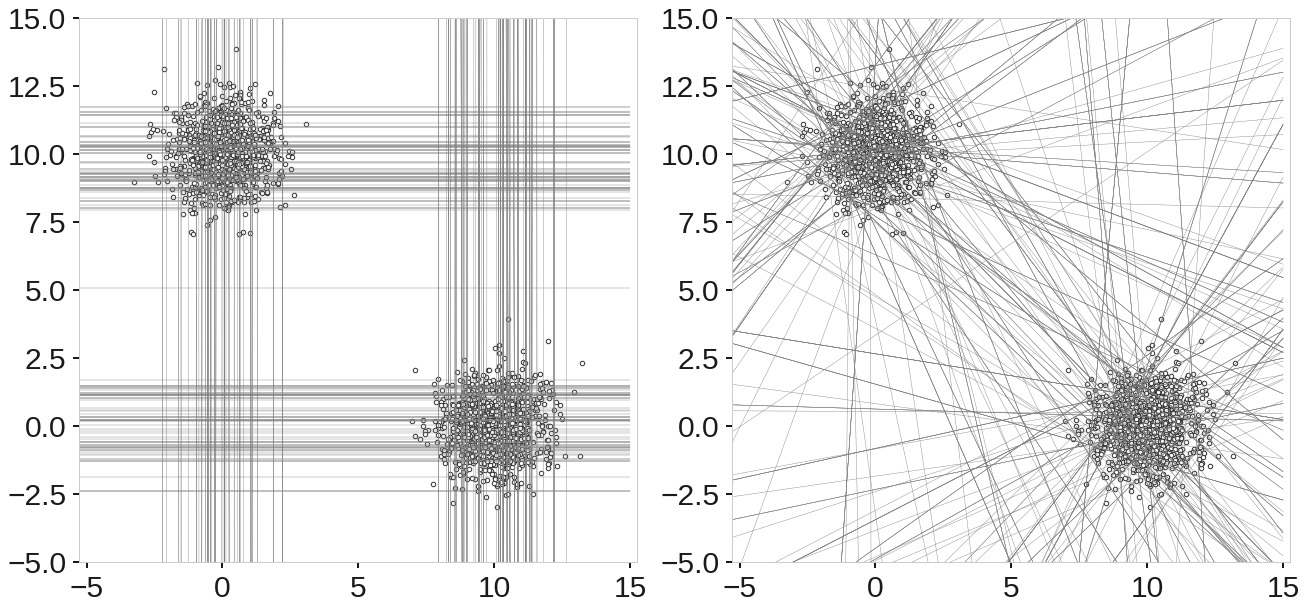

<h6 align="center">Visualization of a tree branching from Extended Isolation Forest paper [2].</h6> 

The general case needs to define a random slope for each branching point (Right picture above).
Instead of selecting the feature and value, it selects a random slope $n$ for
the branching cut and a random intercept $p$.

For Extended Isolation Forest the ``extension_level`` hyperparameter allows you to leverage the generalization of Isolation Forest. 
The number $0$ corresponds to Isolation Forest's behavior because the split points are not randomized with slope. 
For the dataset with $P$ features, the maximum ``extension_level`` is $P-1$ and means full-extension. 
As the ``extension_level`` is increased, the bias of the standard Isolation Forest is reduced. A lower extension is suitable for
a domain where the range of the minimum and maximum for each feature highly differs (for example, when one feature is 
measured in millimeters, and the second one in meters).

The branching criteria in Extended Isolation Forest for the data
splitting for a given data point `x` is: ``(x - p) * n ≤ 0``

where:
 - `x`, `p`, and `n` are vectors with `P` features
 - `p` is random  intercept generated from the uniform distribution with bounds coming from the sub-sample of data to be split.
 - `n` is random slope for the branching cut generated from $\mathcal{N(0,1)}$ distribution.

The function of ``extension_level``
is to force random items of `n` to be zero. The ``extension_level`` hyperparameter value is between `0` and `P-1`.
A value of $0$ means that all slopes will be parallel with all of the axes, which corresponds to Isolation Forest's behavior.
A higher number of extension level indicates that the split will be parallel with ``extension_level``-number of axes.
The full-extension means ``extension_level`` is equal to $P - 1$. This indicates that the slope of the branching point will always be randomized. 

For a full insight into the ``extension_level`` hyperparameter, please read the section High Dimensional Data and Extension
Levels from the original paper [2].

## Visualization of Isolation Forest's bias in 2D

- We will generate two blobs of data from $\mathcal{N[(10,0); (1,1)]}$ and $\mathcal{N[(0,10); (1,1)]}$
- Train Extended Isolation Forest and Isolation Forest simulated by extension_level=0
- Predict the heatmap data and visualize the occurance of ghost clusters around point $[0,0]$ and $[10, 10]$

In [1]:
N = 500
ntrees = 400
sample_size = 256
seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import h2o
import math
import random
from h2o.estimators import H2OIsolationForestEstimator, H2OExtendedIsolationForestEstimator
from sklearn.datasets import make_blobs

versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='master',lastCommitHash='063cdf550249af5ec0ed5f54e8db667ea4295ff1',gitDescribe='jenkins-master-5550',compiledOn='2021-08-28 23:32:47',compiledBy='valen'


In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpqsrt3nqm
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpqsrt3nqm\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpqsrt3nqm\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_valen_llpmiu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


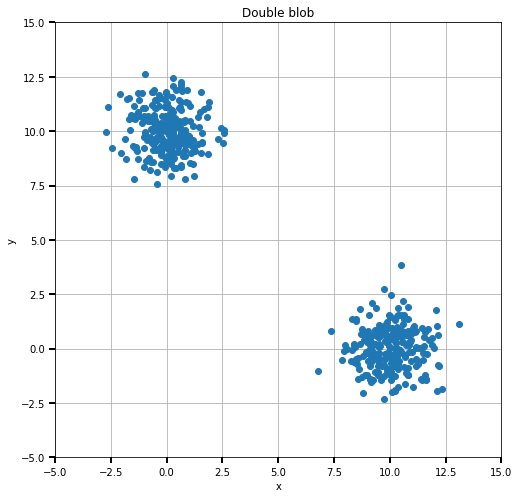

In [4]:
# Define datasets
blobs_params = dict(random_state=seed, n_samples=N, n_features=2)
data = make_blobs(centers=[[10, 0], [0, 10]], cluster_std=[1, 1], **blobs_params)[0]

fig=plt.figure(figsize=(8,8))
fig.add_subplot(111)
plt.plot(data[:,0],data[:,1],'o')
plt.grid("off")
# plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2)
plt.title("Double blob")
plt.show()

In [5]:
training_frame = h2o.H2OFrame(data,column_names = ["x", "y"])

EIF_h2o = H2OExtendedIsolationForestEstimator(
                                              model_id = "extended_isolation_forest.hex",
                                              ntrees = ntrees, 
                                              sample_size = sample_size,
                                              extension_level = 1,
                                              seed = seed
                                             )
EIF_h2o.train(training_frame = training_frame)

IF_h2o = H2OExtendedIsolationForestEstimator(
                                              model_id = "isolation_forest.hex",
                                              ntrees = ntrees, 
                                              sample_size = sample_size,
                                              extension_level = 0,
                                              seed = seed
                                             )
IF_h2o.train(training_frame = training_frame)

print(EIF_h2o)
print(IF_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Model Details
H2OExtendedIsolationForestEstimator :  Extended Isolation Forest
Model Key:  extended_isolation_forest.hex


Model Summary: 


,,number_of_trees,size_of_subsample,extension_level,seed
0,,400,256,1,42




Model Details
H2OExtendedIsolationForestEstimator :  Extended Isolation Forest
Model Key:  isolation_forest.hex


Model Summary: 


,,number_of_trees,size_of_subsample,extension_level,seed
0,,400,256,0,42


In [6]:
granularity = 30

# Heat map data 
xx, yy = np.meshgrid(np.linspace(-5, 15, granularity), np.linspace(-5, 15, granularity))

# H2O
hf_heatmap = h2o.H2OFrame(np.c_[xx.ravel(), yy.ravel()], column_names = ["x", "y"]) 

h2o_anomaly_score_eif = EIF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_eif = h2o_anomaly_score_eif.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_eif = np.array(h2o_anomaly_score_df_eif["anomaly_score"]).reshape(xx.shape)

h2o_anomaly_score_if = IF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_if = h2o_anomaly_score_if.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_if = np.array(h2o_anomaly_score_df_if["anomaly_score"]).reshape(xx.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


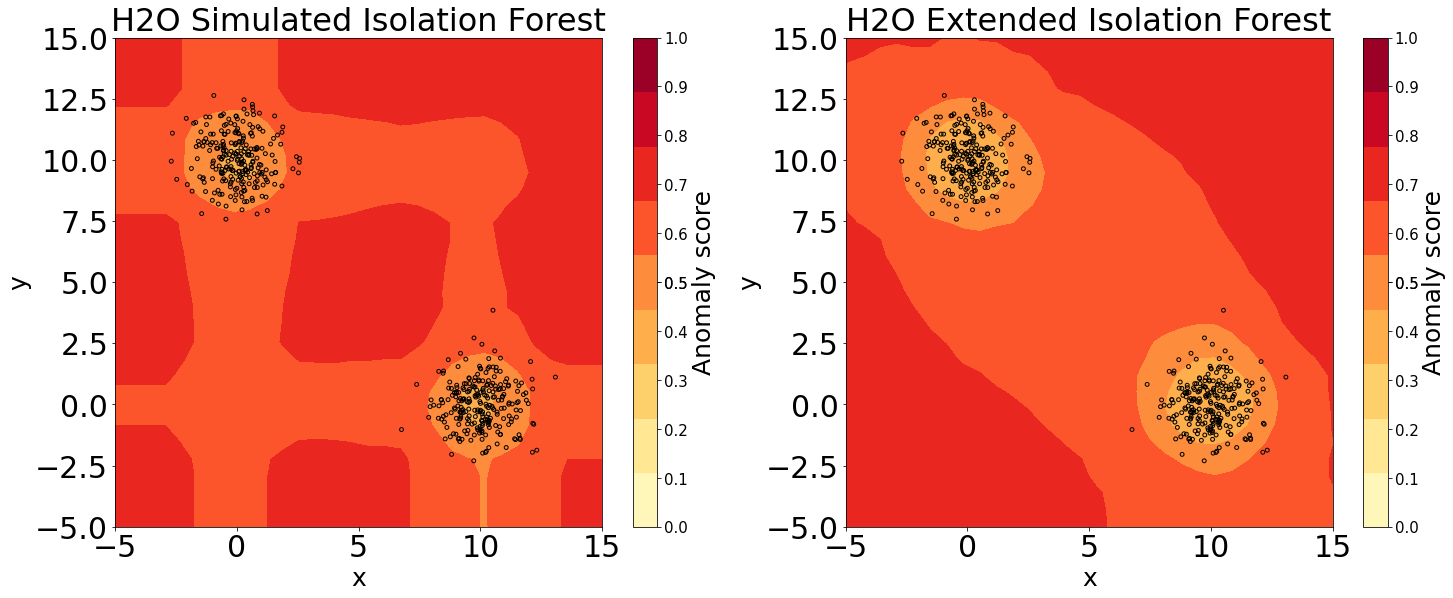

In [7]:
f = plt.figure(figsize=(24, 9))

def plot_heatmap(heatmap_data, subplot, title): 
    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,10, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 25)
    cbar.ax.tick_params(labelsize=15)
    ax1.set_xlabel("x", fontsize = 25)
    ax1.set_ylabel("y", fontsize = 25)
    plt.tick_params(labelsize=30)
    plt.scatter(data[:,0],data[:,1],s=15,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=32)
    
plot_heatmap(heatmap_h2o_if, 121, "H2O Simulated Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 122, "H2O Extended Isolation Forest")

plt.show()

As we can see in the picture above, the occurence of ghost clusters is evident. 

This could lead to false positive anomaly detection since the threshold is used to find anomalies. 

In the table bellow, the difference in the ``anomaly_score`` for points in ghost clusters is between 0.06 to 0.08 which could lead to false positives.

In [8]:
hf1010 = h2o.H2OFrame([[10,10],[0,0]], column_names = ["x", "y"]) 

predictions1010_eif = EIF_h2o.predict(hf1010)
predictions1010_if = IF_h2o.predict(hf1010)

predictions1010_all = predictions1010_eif.cbind(predictions1010_if).cbind(hf1010)
predictions1010_all.rename({"anomaly_score": "anomaly_score_eif", "mean_length": "mean_length_eif", "anomaly_score0": "anomaly_score_if", "mean_length0": "mean_length_if"})

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


anomaly_score_eif,mean_length_eif,anomaly_score_if,mean_length_if,x,y
0.701635,5.23721,0.643139,6.52384,10,10
0.697563,5.32324,0.611796,7.26228,0,0


## Performance analyses of Extended Isolation Forest agains H2OIsolationForestEstimator

As you may know, H2O-3 also provides implementation of standard Isolation Forest. Implementation builds on our DRF and uses a lot of similar features for convinient machine learning. Isolation Forest employs binning and our distributed DTree structure to process vast amount of data. 

Extended Isolation forest implementation is totally independent from current DRF and Isolation Forest and use full potential of sample_size parameter to provide short training time. Focuse on the diagram bellow where is a visualision of training proccess.

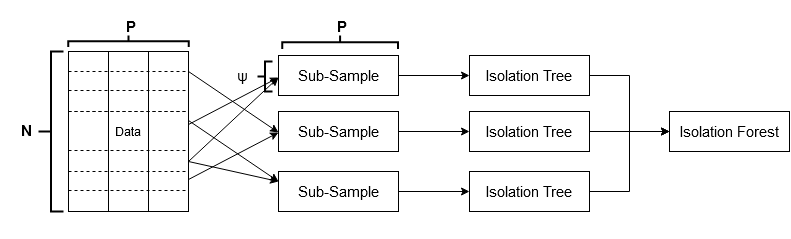

Extended Isolation Forest extract sub sample of the given data and sequientialy train desired number of trees. In the picture below is a benchmark of training process on Credit card dataset. We fix the ntrees=100 and study the sample_size effect. The Credit card dataset has 284 807 number of rows (N) and 30 training features (P).

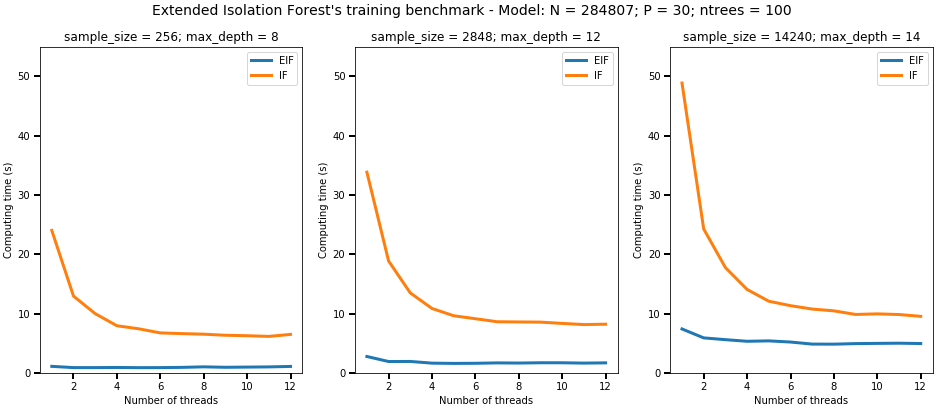

Assumption that sample_size patametr is small [1] is a key performance improvement of H2O's Extended Isolation Forest implementation.

### H2OIsolationForestEstimator
#### Advantages

- Builds on DRF and provides a lot of similar features
- Employes binning and DTree structure
- Can handle large sample_size parameter

#### Limitations

- Loses precison on small data

### H2OExtendedIsolationForestEstimator
#### Advantages

- Keeps the same precison on small and large data
- While provide shorter training time than Isolation Forest

#### Limitations

- sample_size is limited to 100_000 rows

## Anomaly Detection Performance on Credit Card Dataset

We analyse the anomaly detection performance using well known Credit Cards dataset [3]. We took the H2OExtendedIsolatonForestEstimator, H2OIsolatonForestEstimator, Sklearn Isolation Forest [5], and sahandha/eif [6] implementation. Please focuse on AUCPR metric.

Although the Extended Isolation Forest shows high AUCPR, the best model had extension_level=0.

### Reported on validation dataset

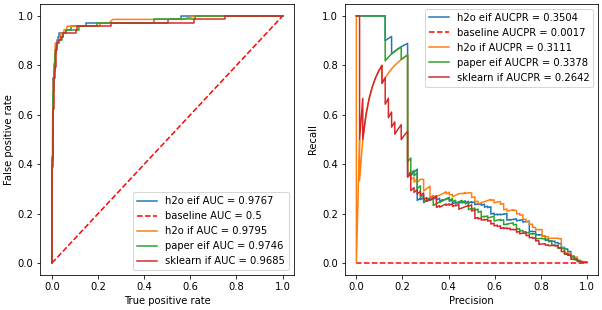

### Reported on test dataset

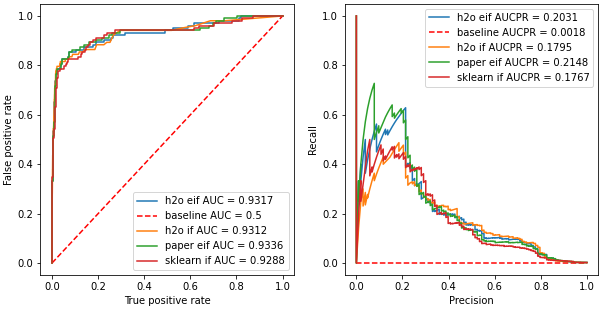

# Credits
- Adam Valenta @valenad1, Software Engineer of H2O-3 Machine Learning open-source platform
- Veronika Maurerová @maurever, Software Engineer of H2O-3 Machine Learning open-source platform
- Michak Kurka @michalkurka, Product owner of H2O-3 Machine Learning open-source platform

# Bibliography

* [1] **Isolation Forest Paper:** F. T. Liu, K. M. Ting and Z. Zhou, "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining, Pisa, 2008, pp. 413-422, doi: 10.1109/ICDM.2008.17. Available from: https://ieeexplore.ieee.org/document/4781136


* [2] **Extended Isolation Forest Paper:** S. Hariri, M. Carrasco Kind and R. J. Brunner, "Extended Isolation Forest," in IEEE Transactions on Knowledge and Data Engineering, doi: 10.1109/TKDE.2019.2947676. Available from:http://dx.doi.org/10.1109/TKDE.2019.2947676


* [3] **Credit cards Kaggle dataset** https://www.kaggle.com/mlg-ulb/creditcardfraud


* [4] **Diploma Thesis about Anomaly Detection and implementation of EIF into H2O-3 library:** https://dspace.cvut.cz/bitstream/handle/10467/87988/F8-DP-2020-Valenta-Adam-thesis.pdf


* [5] **sahandha/eif** https://github.com/sahandha/eif


* [6] **Sklearn Isolation Forest** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.score_samples